# Comparison between sklearn's and gensim's implementations of NMF

In [1]:
%load_ext line_profiler

from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_documents
from gensim import matutils
from sklearn.decomposition.nmf import NMF as SklearnNmf
import sklearn.decomposition.nmf
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from matplotlib import pyplot as plt

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 20newsgroups

In [2]:
from gensim.parsing.preprocessing import preprocess_documents

documents = preprocess_documents(fetch_20newsgroups().data[:1000])

In [3]:
from gensim.corpora import Dictionary

dictionary = Dictionary(documents)

2018-04-22 16:56:15,042 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-22 16:56:15,285 : INFO : built Dictionary(17622 unique tokens: ['addit', 'bodi', 'bricklin', 'brought', 'bumper']...) from 1000 documents (total 136081 corpus positions)


In [4]:
corpus = [
    dictionary.doc2bow(document)
    for document
    in documents
]

bow_matrix = matutils.corpus2dense(corpus, len(dictionary), len(corpus))

## Sklearn NMF

In [5]:
%%time
# %%prun

sklearn_nmf = SklearnNmf(n_components=5, tol=1e-5, max_iter=int(1e9), random_state=42)

W = sklearn_nmf.fit_transform(bow_matrix)
H = sklearn_nmf.components_

CPU times: user 6 s, sys: 3.64 s, total: 9.63 s
Wall time: 5.47 s


In [6]:
# %lprun -f sklearn.decomposition.nmf._fit_coordinate_descent sklearn_nmf.fit_transform(bow_matrix)

In [7]:
np.linalg.norm(bow_matrix - W.dot(H), 'fro')

554.6444386890174

## Gensim NMF

In [8]:
%%time
# %%prun

np.random.seed(42)

gensim_nmf = GensimNmf(corpus, chunksize=len(corpus) / 10, num_topics=5, id2word=dictionary, lambda_=1000., kappa=1.)

2018-04-22 16:56:36,217 : INFO : Loss (no outliers): 172.39495291355695	Loss (with outliers): 172.39495291355695
2018-04-22 16:56:43,876 : INFO : Loss (no outliers): 389.3105355433292	Loss (with outliers): 389.3105355433292
2018-04-22 16:56:48,380 : INFO : Loss (no outliers): 145.9595486163495	Loss (with outliers): 145.9595486163495
2018-04-22 16:56:51,592 : INFO : Loss (no outliers): 151.99480174778157	Loss (with outliers): 151.99480174778157
2018-04-22 16:56:54,430 : INFO : Loss (no outliers): 177.2928353871849	Loss (with outliers): 177.2928353871849
2018-04-22 16:56:58,282 : INFO : Loss (no outliers): 188.18409794869066	Loss (with outliers): 188.18409794869066
2018-04-22 16:57:02,207 : INFO : Loss (no outliers): 160.50397978534247	Loss (with outliers): 160.50397978534247
2018-04-22 16:57:05,956 : INFO : Loss (no outliers): 237.7479754187301	Loss (with outliers): 237.7479754187301
2018-04-22 16:57:07,425 : INFO : Loss (no outliers): 148.60375147751577	Loss (with outliers): 148.603751

CPU times: user 55.8 s, sys: 1min 2s, total: 1min 58s
Wall time: 36.7 s


In [9]:
# %lprun -f GensimNmf._solveproj GensimNmf(corpus, chunksize=len(corpus), num_topics=5, id2word=dictionary, lambda_=1000., kappa=1.)

In [10]:
W, _ = gensim_nmf.get_factor_matrices()
H, R = gensim_nmf.transform(corpus, return_r=True)

In [11]:
np.linalg.norm(matutils.corpus2dense(corpus, len(dictionary), len(documents)) - W.dot(H), 'fro')

678.6977129611604

From the personal experience I can say that the higher number of passes and shuffle of the trainset significantly improves performance.

Then, of course, you should perform hyperparameter tuning.

# Image of stars
### (For the sake of visualization of performance on sparse trainset)

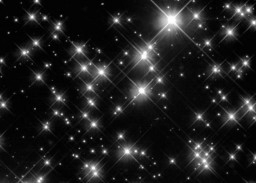

In [12]:
from PIL import Image
img = Image.open('stars_scaled.jpg').convert('L')
img

In [13]:
img_matrix = np.uint8(img.getdata()).reshape(img.size[::-1])
img_matrix.shape

(183, 256)

## Sklearn NMF

In [14]:
%%time

sklearn_nmf = SklearnNmf(n_components=10, tol=1e-5, max_iter=int(1e9))

W = sklearn_nmf.fit_transform(img_matrix)
H = sklearn_nmf.components_

CPU times: user 227 ms, sys: 224 ms, total: 452 ms
Wall time: 253 ms


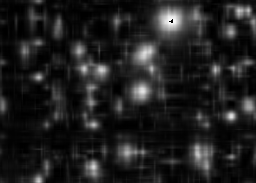

In [15]:
Image.fromarray(np.uint8(W.dot(H)), 'L')

## Gensim NMF

In [43]:
%%time

import itertools

np.random.seed(42)

img_corpus = matutils.Dense2Corpus(img_matrix[np.random.choice(img_matrix.shape[0], img_matrix.shape[0], replace=False)].T)

gensim_nmf = GensimNmf(
    img_corpus,
    chunksize=40,
    num_topics=10,
    id2word={k: k for k in range(img_matrix.shape[1])},
    lambda_=1000.,
    kappa=1.
)

2018-04-22 17:02:33,972 : INFO : Loss (no outliers): 4649.176186445958	Loss (with outliers): 4649.176186445958
2018-04-22 17:02:34,794 : INFO : Loss (no outliers): 2545.831439439685	Loss (with outliers): 2545.831439439685
2018-04-22 17:02:35,144 : INFO : Loss (no outliers): 2157.622569525167	Loss (with outliers): 2157.622569525167
2018-04-22 17:02:35,348 : INFO : Loss (no outliers): 2111.146762974082	Loss (with outliers): 2111.146762974082
2018-04-22 17:02:35,464 : INFO : Loss (no outliers): 1428.3477896008337	Loss (with outliers): 1428.3477896008337


CPU times: user 1.62 s, sys: 2.4 ms, total: 1.62 s
Wall time: 1.62 s


In [44]:
W, _ = gensim_nmf.get_factor_matrices()
H, R = gensim_nmf.transform(matutils.Dense2Corpus(img_matrix.T), return_r=True)

### Reconstructed matrix:

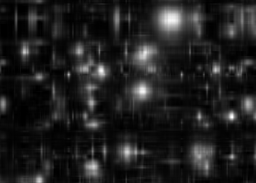

In [45]:
Image.fromarray(np.uint8(W.dot(H).T), 'L')

### Residuals:

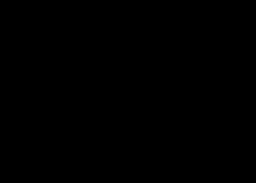

In [46]:
Image.fromarray(np.uint8(R.T), 'L')